# Research Question 2

Is it possible to predict the success of future instalments of a movie/game?\
Does the failure of an initial movie/game indicate commercial failures of subsequent ones? Can a franchise recover from a flop?


In [1]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
df = pd.read_csv("franchises_combined_by_year.csv", index_col = 0)

In [4]:
df = df.groupby('franchise_id').agg(min_year=('year', 'min'), max_year=('year', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right') \
       .assign(position_in_franchise=lambda x: (x['year'] - x['min_year']) / (x['max_year'] - x['min_year']) * 100)

In [5]:
df = df.groupby('franchise_id').agg(min_vote=('votes_average', 'min'), max_vote=('votes_average', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right')


In [6]:
df = df.groupby('franchise_id').agg(min_rating=('rating_average', 'min'), max_rating=('rating_average', 'max')) \
       .reset_index() \
       .merge(df, on='franchise_id', how='right')

In [7]:
idx = df.groupby('franchise_id')['rating_average'].idxmin()

# Select the year value at the index and assign it to a new column for every row with the same franchise_id
df['lowest_rated_year'] = df.loc[idx, 'year'].values.repeat(df.groupby('franchise_id').size())
df['lowest_rated_pos'] = df.loc[idx, 'position_in_franchise'].values.repeat(df.groupby('franchise_id').size())

In [8]:
df["pos_rel_to_lowest_year"] = df.apply(lambda x: 'pre' if x['year'] < x['lowest_rated_year'] else ('post' if x['year'] > x['lowest_rated_year'] else 'lowest'), axis=1)

In [9]:
df['avg_pre_rating'] = df.groupby('franchise_id')['rating_average'].transform(lambda x: x.loc[df['pos_rel_to_lowest_year'] == 'pre'].mean())
df['avg_post_rating'] = df.groupby('franchise_id')['rating_average'].transform(lambda x: x.loc[df['pos_rel_to_lowest_year'] == 'post'].mean())

In [26]:
df.avg_pre_rating.value_counts()

7.100000    135
7.800000    132
7.500000    123
7.700000    120
7.000000    114
           ... 
5.433333      2
8.250000      2
5.450000      2
6.900000      2
7.700000      2
Name: avg_pre_rating, Length: 626, dtype: int64

In [11]:
df = df.groupby('franchise_id').apply(lambda x: x.assign(diff_between_pre_and_lowest = x['min_rating'] - x['avg_pre_rating'])).reset_index(level=0, drop=True)
df = df.groupby('franchise_id').apply(lambda x: x.assign(diff_between_post_and_lowest = x['avg_post_rating'] - x['min_rating'])).reset_index(level=0, drop=True)

We can get the average difference in rating when a subsequent release is rated lower.

In [12]:
df['rolling_mean'] = df.groupby('franchise_id')['rating_average'].expanding().mean().reset_index(0, drop=True)
df['diff_from_rolling_mean']= df.groupby('franchise_id')['rolling_mean'].diff()

In [13]:
df[df['diff_between_post_and_lowest'] < -df['diff_between_pre_and_lowest']].franchise_id.nunique()

580

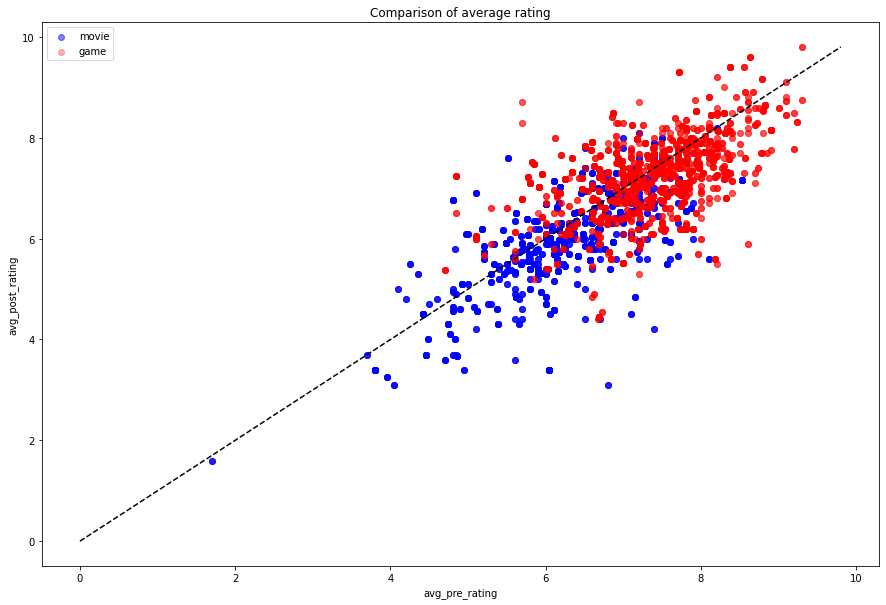

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))

# create separate dataframes for movie and game content types
df_movie = df[df['type'] == 'movie']
df_game = df[df['type'] == 'game']

# plot movie data as blue scatter plot
plt.scatter(df_movie['avg_pre_rating'], df_movie['avg_post_rating'], c='blue', label='movie', alpha = 0.5)

# plot game data as red scatter plot
plt.scatter(df_game['avg_pre_rating'], df_game['avg_post_rating'], c='red', label='game', alpha = 0.3)

# draw a diagonal line from the origin
max_val = max(df['avg_pre_rating'].max(), df['avg_post_rating'].max())
plt.plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels
plt.title('Comparison of average rating')
plt.xlabel('avg_pre_rating',)
plt.ylabel('avg_post_rating')

# set legend
plt.legend()

# show the plot
plt.show()


In [34]:
df[df["franchise_id"] == '3025-1889']['diff_between_pre_and_lowest']

1829   -3.1
1830   -3.1
1831   -3.1
1832   -3.1
Name: diff_between_pre_and_lowest, dtype: float64

In [44]:
df_movie.franchise_count[7305]

11.0

In [46]:
df_movie

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest,diff_between_post_and_lowest,rolling_mean,diff_from_rolling_mean
7305,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0032123,what a life,1939,0,75,"['Comedy', 'Drama']",93.000000,6.90,11.0,1.0,NaN,NaN,NaN,NaN,0.767931,-0.330874,0.000000,1940,20.0,pre,6.9,7.025,-0.9,1.025,6.900000,NaN
7306,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033834,life with henry,1940,0,80,"['Comedy', 'Family', 'Music']",49.000000,6.00,11.0,1.0,1.0,-44.000000,-0.90,0.0,-0.013058,-0.331116,20.000000,1940,20.0,lowest,6.9,7.025,-0.9,1.025,6.450000,-0.450000
7307,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033708,henry aldrich for president,1941,0,75,"['Comedy', 'Family']",146.000000,6.60,11.0,1.0,1.0,97.000000,0.60,0.0,0.507601,-0.330582,40.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.500000,0.050000
7308,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0034842, tt0034844","henry aldrich, editor, henry and dizzy",1942,0,72,"['Comedy', 'Family', 'Drama']",104.000000,6.80,11.0,2.0,1.0,-42.000000,0.20,1.0,0.681154,-0.330813,60.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.575000,0.075000
7309,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0035985, tt0035983, tt0035984","henry aldrich swings it, henry aldrich gets gl...",1943,0,64,"['Comedy', 'Family', 'Adventure']",130.333333,7.00,11.0,3.0,1.0,26.333333,0.20,1.0,0.854707,-0.330669,80.000000,1940,20.0,post,6.9,7.025,-0.9,1.025,6.660000,0.085000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Comedy', 'Drama']",99.000000,6.40,3.0,1.0,2.0,-212.000000,-0.50,0.0,0.334048,-0.330841,50.000000,1950,50.0,lowest,6.9,7.000,-0.5,0.600,6.650000,-0.250000
11379,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Comedy', 'Romance']",658.000000,7.00,3.0,1.0,2.0,559.000000,0.60,0.0,0.854707,-0.327767,100.000000,1950,50.0,post,6.9,7.000,-0.5,0.600,6.766667,0.116667
11380,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Romance', 'Horror', 'Sci-Fi']",5449.500000,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.531648,-0.301416,0.000000,1974,0.0,lowest,NaN,5.000,NaN,0.750,4.250000,NaN
11381,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.000000,5.20,4.0,1.0,4.0,-2955.500000,0.95,-1.0,-0.707271,-0.317670,30.769231,1974,0.0,post,NaN,5.000,NaN,0.750,4.725000,0.475000


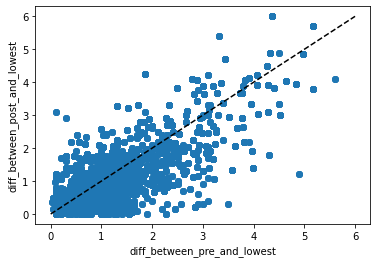

In [14]:
plt.scatter(-df['diff_between_pre_and_lowest'], df['diff_between_post_and_lowest'])

# draw a diagonal line from the origin
plt.plot([0, max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())], [0, max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())], 'k--')

# set the x and y axis labels
plt.xlabel('diff_between_pre_and_lowest')
plt.ylabel('diff_between_post_and_lowest')

# show the plot
plt.show()

In [154]:
df.sort_values('diff_from_rolling_mean').head(50)

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,lowest_rated_year,lowest_rated_pos,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest,diff_between_post_and_lowest,rolling_mean,diff_from_rolling_mean
6790,3025-816,2.20,7.80,11.0,27.000000,2005,2015,America's Army,game,tt1090640,America's Army: True Soldiers,2007,0,NaN,"[""['Action'"", "" 'Shooter']""]",25.0,2.20,3.0,1.0,2.0,-2.0,-5.60,0.0,-4.551525,-0.248558,20.000000,2007,20.000000,lowest,7.800000,6.300000,-5.600000,4.100000,5.000000,-2.800000
11143,f895,1.90,6.80,38.0,2330.000000,2011,2013,Evil Born,movie,tt2313780,12/12/12,2012,0,86,['Horror'],1620.0,1.90,3.0,1.0,1.0,1582.0,-4.90,0.0,-3.570897,-0.322476,50.000000,2012,50.000000,lowest,6.800000,3.100000,-4.900000,1.200000,4.350000,-2.450000
1795,3025-1866,2.50,7.40,8.0,66.000000,1985,2013,The Wizard of Oz,game,tt2887448,The Wizard of Oz,1993,0,NaN,"["" 'Fantasy']"", ""['Adventure'""]",37.0,2.50,3.0,1.0,8.0,29.0,-4.50,0.0,-4.272887,-0.243469,28.571429,1993,28.571429,lowest,7.000000,7.400000,-4.500000,4.900000,4.750000,-2.250000
4297,3025-409,3.10,8.10,9.0,1127.000000,1995,2019,Rayman,game,tt8535032,Rayman Brain Games,1996,0,NaN,"["" 'Educational']"", ""['Family'""]",9.0,3.10,16.0,1.0,1.0,-753.0,-4.40,0.0,-3.715611,-0.255343,4.166667,1996,4.166667,lowest,7.500000,6.925000,-4.400000,3.825000,5.300000,-2.200000
8739,f173,3.80,8.10,12172.0,417943.000000,1973,2005,The Exorcist,movie,tt0076009,exorcist ii: the heretic,1977,0,117,['Horror'],25719.0,3.80,5.0,1.0,4.0,-392224.0,-4.30,0.0,-1.922142,-0.189946,12.500000,1977,12.500000,lowest,8.100000,5.600000,-4.300000,1.800000,5.950000,-2.150000
11103,f882,3.40,7.30,40755.0,394057.000000,1994,2014,Dumb and Dumber,movie,tt0329028,dumb and dumberer: when harry met lloyd,2003,0,85,['Comedy'],40755.0,3.40,3.0,1.0,9.0,-353302.0,-3.90,0.0,-2.269249,-0.107257,45.000000,2003,45.000000,lowest,7.300000,5.600000,-3.900000,2.200000,5.350000,-1.950000
501,3025-1203,3.70,7.50,6.0,669.000000,1983,2002,Dragon's Lair,game,tt3034468,Dragon's Lair,1990,0,NaN,"[""['Puzzle'"", "" 'Adventure']""]",49.0,3.70,5.0,1.0,7.0,-620.0,-3.80,0.0,-3.158335,-0.238381,36.842105,1990,36.842105,lowest,7.500000,6.333333,-3.800000,2.633333,5.600000,-1.900000
9072,f271,3.40,8.50,6.0,678672.000000,1979,2021,Apocalypse,movie,tt0161942,revelation,1999,0,98,"['Action', 'Horror', 'Drama']",1057.0,4.80,8.0,1.0,20.0,-677615.0,-3.70,0.0,-1.054377,-0.325572,47.619048,2017,90.476190,pre,6.000000,4.700000,-2.600000,1.300000,6.650000,-1.850000
11060,f865,3.90,7.40,4266.0,16869.000000,2007,2019,Dhamaal,movie,tt1728239,double dhamaal,2011,0,138,"['Comedy', 'Crime', 'Drama']",4266.0,3.90,3.0,1.0,4.0,-12603.0,-3.50,0.0,-1.835366,-0.307925,33.333333,2011,33.333333,lowest,7.400000,4.200000,-3.500000,0.300000,5.650000,-1.750000
9387,f377,2.10,5.55,158.5,169.000000,1968,1971,Journey to the Unknown,movie,tt0329247,journey to murder,1971,0,100,"['Mystery', 'Horror', 'Drama']",169.0,2.10,3.0,1.0,3.0,10.5,-3.45,-1.0,-3.397344,-0.330456,100.000000,1971,100.000000,lowest,5.550000,NaN,-3.450000,NaN,3.825000,-1.725000


<AxesSubplot:>

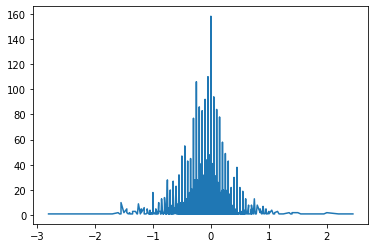

In [25]:
df.diff_from_rolling_mean.value_counts().sort_index().plot()

In [18]:
df[df['rating_diff'] < 0].rating_diff.describe()

count    5.028000e+03
mean    -8.543681e-01
std      7.666299e-01
min     -6.700000e+00
25%     -1.200000e+00
50%     -6.000000e-01
75%     -3.000000e-01
max     -8.881784e-16
Name: rating_diff, dtype: float64

In [48]:
franchise_grouped_df = df.groupby('franchise_id').agg(    
    franchise_name = ('franchise_name', 'last'),
    total_running_length_years=('year', lambda x: (x.max() - x.min()) +1),
    releases_in_franchise=('franchise_count', 'max'),
    content_type = ('type', 'last'),
    avg_pre_rating = ('avg_pre_rating', 'last'),
    average_rating = ('rating_average', 'mean'),
    lowest_rating = ('min_rating', 'first'),
    avg_post_rating = ('avg_post_rating', 'last'),
    average_votes = ('votes_average', 'mean'),
    lowest_rated_year = ('lowest_rated_year', 'last'),
    pos_in_fran_lowest_rated = ('lowest_rated_pos', 'last'),
    diff_between_post_and_lowest = ('diff_between_post_and_lowest', 'last'),
    diff_between_pre_and_lowest = ('diff_between_pre_and_lowest', 'last')
)

In [59]:
type(franchise_grouped_df_movie.releases_in_franchise[])

numpy.float64

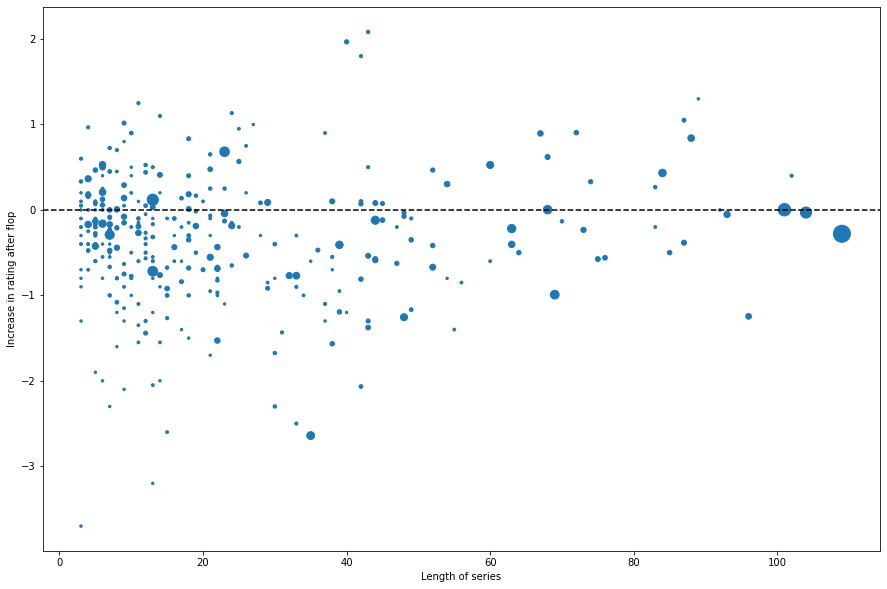

In [115]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.scatter(y=franchise_grouped_df_movie['diff_pre_vs_post'], x=franchise_grouped_df_movie['total_running_length_years'], s = franchise_grouped_df_movie['releases_in_franchise']*2)
plt.axhline(y=0, linestyle='--', color='black')
plt.ylabel('Increase in rating after flop')
plt.xlabel('Length of series')
#plt.xscale('log')
plt.show()


In [139]:
franchise_grouped_df_movie

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest
franchise_id,,,,,,,,,,,,,
f0,The Aldrich Family,6,11.0,movie,6.900000,6.833333,6.00,7.025,104.722222,1940,20.000000,1.025,-0.900000
f1,Coffin Joe,42,10.0,movie,6.160000,5.690000,4.70,5.350,718.900000,1976,21.951220,0.650,-1.460000
f100,Dik Trom,70,6.0,movie,6.033333,5.916667,5.60,5.900,191.166667,1974,47.826087,0.300,-0.433333
f1000,Jesse James (Republic serials),3,3.0,movie,NaN,6.666667,6.30,6.850,132.666667,1947,0.000000,0.550,NaN
f1001,Jiang tou,45,4.0,movie,NaN,6.275000,6.20,6.300,1125.250000,1975,0.000000,0.100,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
f989,Inspector Hornleigh,3,3.0,movie,6.750000,6.725000,6.70,NaN,258.000000,1941,100.000000,NaN,-0.050000
f99,The Conjuring Universe,9,8.0,movie,6.675000,6.264286,5.30,5.925,205675.000000,2018,62.500000,0.625,-1.375000
f992,I soliti ignoti,28,3.0,movie,7.450000,6.766667,5.40,NaN,4053.333333,1985,100.000000,NaN,-2.050000


In [107]:
franchise_grouped_df_movie['diff_pre_vs_post'] = franchise_grouped_df_movie.apply(lambda x: x['avg_post_rating'] - x['avg_pre_rating'], axis = 1)

<ipython-input-107-4228d34c0bd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  franchise_grouped_df_movie['diff_pre_vs_post'] = franchise_grouped_df_movie.apply(lambda x: x['avg_post_rating'] - x['avg_pre_rating'], axis = 1)


In [146]:
franchise_grouped_df_movie[franchise_grouped_df_movie['avg_pre_rating'] == franchise_grouped_df_movie['avg_post_rating']]

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest
franchise_id,,,,,,,,,,,,,
f1049,Lucky Stars (Secondary Trilogy),7,3.0,movie,5.4,5.366667,5.30,5.4,227.666667,1989,50.000000,0.10,-0.10
f1091,My Wife Is a Gangster,6,3.0,movie,6.3,6.200000,6.00,6.3,2138.666667,2003,40.000000,0.30,-0.30
f1107,Noriko,5,3.0,movie,8.2,8.166667,8.10,8.2,30134.000000,1951,50.000000,0.10,-0.10
f1271,"Wally ""The Fox"" Benton",3,3.0,movie,6.7,6.633333,6.50,6.7,794.000000,1942,50.000000,0.20,-0.20
f270,Anne of Green Gables,92,3.0,movie,7.2,7.133333,7.00,7.2,597.000000,1934,16.483516,0.20,-0.20
f776,BRD Trilogy,4,4.0,movie,7.7,7.450000,6.95,7.7,8320.666667,1981,66.666667,0.75,-0.75
f960,The Happy Hooker,6,3.0,movie,3.7,3.600000,3.40,3.7,857.666667,1977,40.000000,0.30,-0.30


In [152]:
len(franchise_grouped_df_movie[franchise_grouped_df_movie['avg_pre_rating'] < franchise_grouped_df_movie['avg_post_rating']]) / len(franchise_grouped_df_movie.dropna())

0.2823529411764706

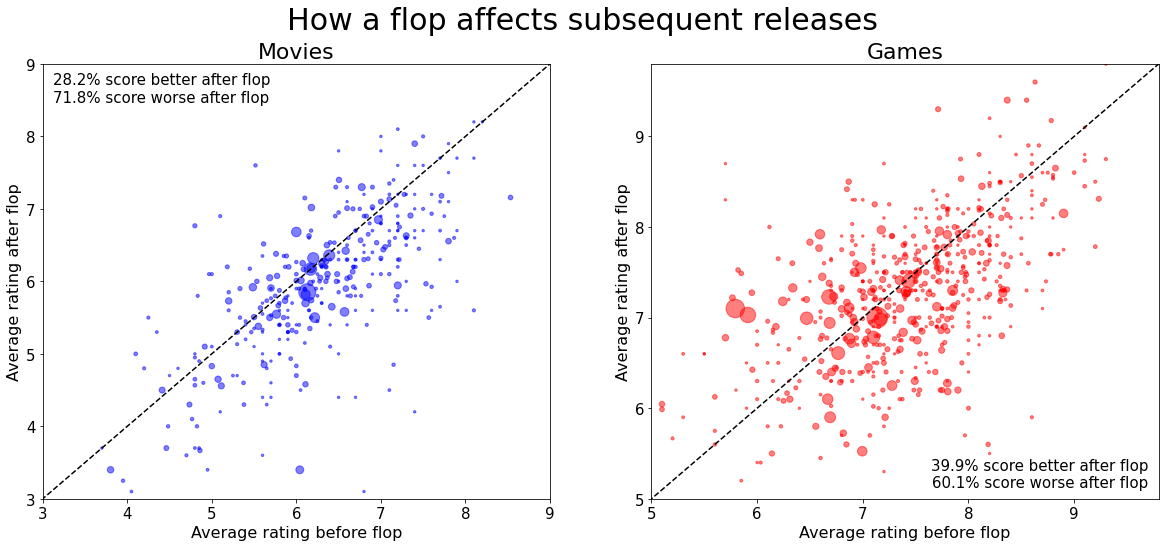

In [153]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8)) # create a figure with 2 columns of subplots

# create separate dataframes for movie and game content types
franchise_grouped_df_movie = franchise_grouped_df[(franchise_grouped_df['content_type'] == 'movie')]
franchise_grouped_df_game = franchise_grouped_df[(franchise_grouped_df['content_type'] == 'game')]
##### & (franchise_grouped_df['diff_between_pre_and_lowest'] < -2)

# plot movie data as blue scatter plot
axs[0].scatter(x=franchise_grouped_df_movie['avg_pre_rating'], y=franchise_grouped_df_movie['avg_post_rating'], s=franchise_grouped_df_movie['releases_in_franchise']*2, color='blue', label='movie', alpha=0.5)

# plot game data as red scatter plot
axs[1].scatter(x=franchise_grouped_df_game['avg_pre_rating'], y=franchise_grouped_df_game['avg_post_rating'], s=franchise_grouped_df_game['releases_in_franchise']*2, color='red', label='game', alpha=0.5)

# set the same diagonal line from the origin for both subplots
max_val = max(df['avg_pre_rating'].max(), df['avg_post_rating'].max())
axs[0].plot([0, max_val], [0, max_val], 'k--')
axs[1].plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels for both subplots
fig.suptitle('How a flop affects subsequent releases', fontsize = 30)
axs[0].set_title('Movies', fontsize = 22)
axs[0].set_xlabel('Average rating before flop', fontsize = 16,)
axs[0].set_ylabel('Average rating after flop', fontsize = 16)
axs[1].set_title('Games', fontsize = 22)
axs[1].set_xlabel('Average rating before flop', fontsize = 16)
axs[1].set_ylabel('Average rating after flop', fontsize = 16)
axs[0].tick_params(labelsize=15)
axs[1].tick_params(labelsize=15)

axs[0].set_xlim([3, 9])
axs[0].set_ylim([3, 9])
axs[1].set_xlim([5, max_val])
axs[1].set_ylim([5, max_val])

# calculate the percentage of points above and below the line for each subplot
movie_above_line = 100 * len(franchise_grouped_df_movie[franchise_grouped_df_movie['avg_post_rating'] > franchise_grouped_df_movie['avg_pre_rating']]) / len(franchise_grouped_df_movie.dropna())
game_above_line = 100 * len(franchise_grouped_df_game[franchise_grouped_df_game['avg_post_rating'] > franchise_grouped_df_game['avg_pre_rating']]) / len(franchise_grouped_df_game.dropna())
movie_below_line = 100 - movie_above_line
game_below_line = 100 - game_above_line

# add the percentage of points above and below the line to each subplot
axs[0].text(0.02, 0.98, f'{movie_above_line:.1f}% score better after flop\n{movie_below_line:.1f}% score worse after flop', transform=axs[0].transAxes, va='top', ha='left', fontsize=15)
axs[1].text(0.98, 0.02, f'{game_above_line:.1f}% score better after flop\n{game_below_line:.1f}% score worse after flop', transform=axs[1].transAxes, va='bottom', ha='right', fontsize=15)


# show the plot
plt.show()


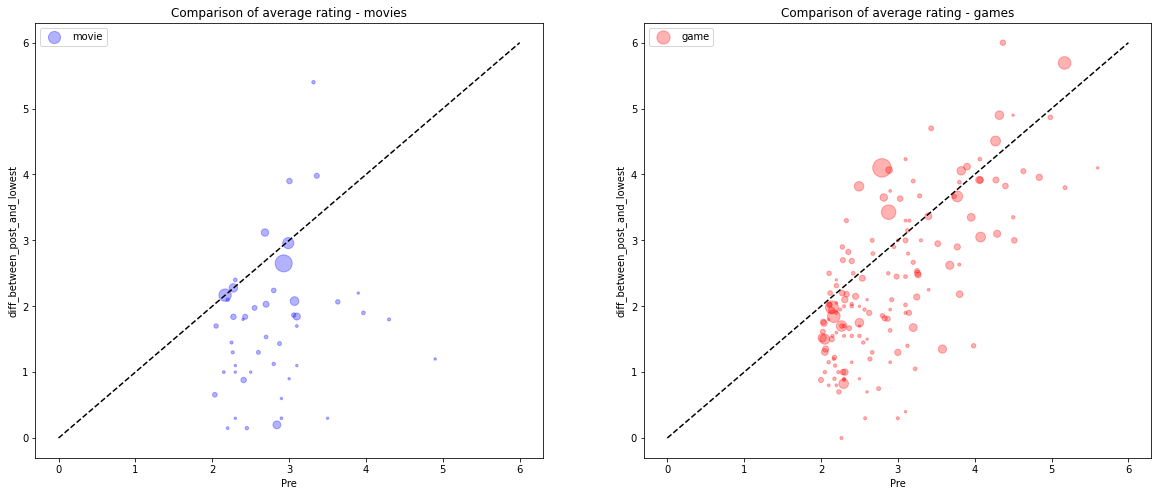

In [82]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8)) # create a figure with 2 columns of subplots

# create separate dataframes for movie and game content types
franchise_grouped_df_movie = franchise_grouped_df[(franchise_grouped_df['content_type'] == 'movie') & (franchise_grouped_df['diff_between_pre_and_lowest'] < -2)]
franchise_grouped_df_game = franchise_grouped_df[(franchise_grouped_df['content_type'] == 'game')  & (franchise_grouped_df['diff_between_pre_and_lowest'] < -2)]

# plot movie data as blue scatter plot
axs[0].scatter(x=-franchise_grouped_df_movie['diff_between_pre_and_lowest'], y=franchise_grouped_df_movie['diff_between_post_and_lowest'], s=franchise_grouped_df_movie['releases_in_franchise']*2, color='blue', label='movie', alpha=0.3)

# plot game data as red scatter plot
axs[1].scatter(x=-franchise_grouped_df_game['diff_between_pre_and_lowest'], y=franchise_grouped_df_game['diff_between_post_and_lowest'], s=franchise_grouped_df_game['releases_in_franchise']*2, color='red', label='game', alpha=0.3)

# set the same diagonal line from the origin for both subplots
max_val = max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())
axs[0].plot([0, max_val], [0, max_val], 'k--')
axs[1].plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels for both subplots
axs[0].set_title('Comparison of average rating - movies')
axs[0].set_xlabel('Pre')
axs[0].set_ylabel('diff_between_post_and_lowest')
axs[1].set_title('Comparison of average rating - games')
axs[1].set_xlabel('Pre')
axs[1].set_ylabel('diff_between_post_and_lowest')

# set legend for both subplots
axs[0].legend()
axs[1].legend()

# show the plot
plt.show()


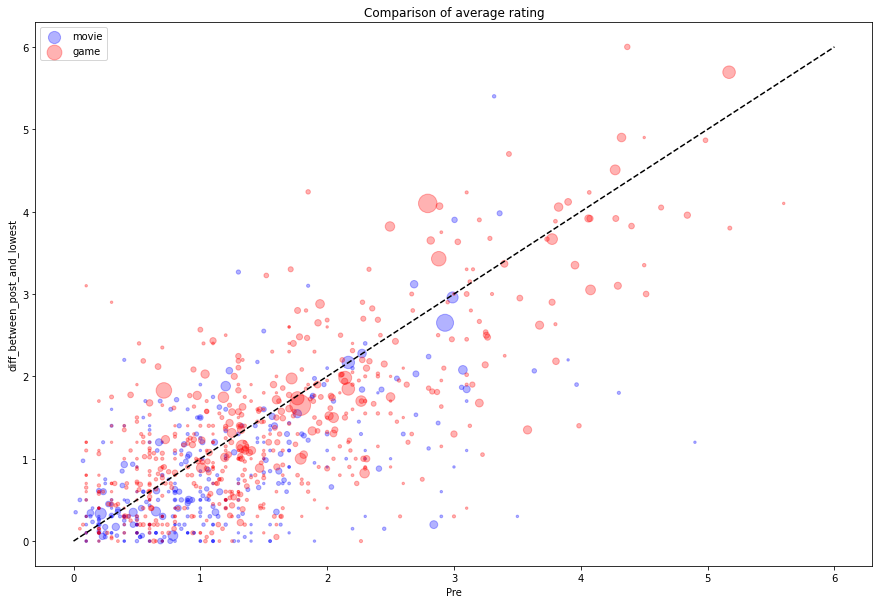

In [77]:
fig, ax = plt.subplots(figsize=(15, 10))

# create separate dataframes for movie and game content types
franchise_grouped_df_movie = franchise_grouped_df[franchise_grouped_df['content_type'] == 'movie']
franchise_grouped_df_game = franchise_grouped_df[franchise_grouped_df['content_type'] == 'game']

# plot movie data as blue scatter plot
plt.scatter(x = -franchise_grouped_df_movie['diff_between_pre_and_lowest'], y = franchise_grouped_df_movie['diff_between_post_and_lowest'], s=franchise_grouped_df_movie['releases_in_franchise']*2, color='blue', label='movie', alpha = 0.3,)

# plot game data as red scatter plot
plt.scatter(-franchise_grouped_df_game['diff_between_pre_and_lowest'], franchise_grouped_df_game['diff_between_post_and_lowest'], s=franchise_grouped_df_game['releases_in_franchise']*2, color='red', label='game', alpha = 0.3)

#plt.scatter(-franchise_grouped_df[franchise_grouped_df["franchise_name"] == 'Marvel']['diff_between_pre_and_lowest'], franchise_grouped_df[franchise_grouped_df["franchise_name"] == 'Marvel']['diff_between_post_and_lowest'], s=franchise_grouped_df['releases_in_franchise'], color='green')
# draw a diagonal line from the origin
max_val = max(df['diff_between_pre_and_lowest'].max(), df['diff_between_post_and_lowest'].max())
plt.plot([0, max_val], [0, max_val], 'k--')

# set the x and y axis labels
plt.title('Comparison of average rating')
plt.xlabel('Pre',)
plt.ylabel('diff_between_post_and_lowest')

# set legend
plt.legend()

# show the plot
plt.show()


In [14]:
franchise_grouped_df['average_year_gap_between_releases'] = franchise_grouped_df['total_running_length_years'] / franchise_grouped_df['releases_in_franchise']

<AxesSubplot:>

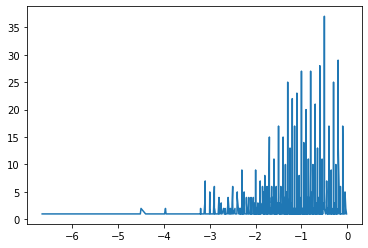

In [15]:
franchise_grouped_df.diff_between_pre_and_lowest.value_counts().sort_index().plot()

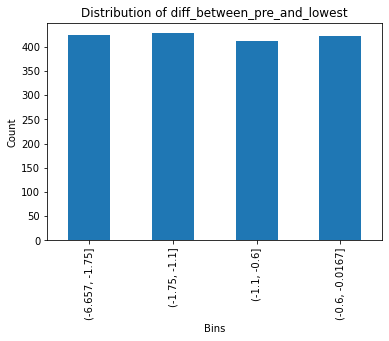

In [138]:
bins = pd.qcut(franchise_grouped_df.diff_between_pre_and_lowest, 4)

# Get the counts of values in each bin
counts = bins.value_counts().sort_index()

# Plot a histogram of the bin counts
counts.plot(kind='bar')
plt.xlabel('Bins')
plt.ylabel('Count')
plt.title('Distribution of diff_between_pre_and_lowest')
plt.show()

In [139]:
bins.value_counts().sort_index()

(-6.657, -1.75]    424
(-1.75, -1.1]      428
(-1.1, -0.6]       413
(-0.6, -0.0167]    422
Name: diff_between_pre_and_lowest, dtype: int64

The reason we are doing this is because we don't want to assume that a franchise that just gradually decreased in rating died as a result of their last release being a flop. This is why we are taking into account only those franchises where there was a significant drop below the average

In [16]:
franchise_grouped_df[(franchise_grouped_df['diff_between_pre_and_lowest']>-0.5)].content_type.value_counts()

movie    166
game     110
Name: content_type, dtype: int64

In [17]:
franchise_grouped_df[(franchise_grouped_df['diff_between_pre_and_lowest'] < -2) & (franchise_grouped_df['pos_in_fran_lowest_rated'] != 100)]

,franchise_name,total_running_length_years,releases_in_franchise,content_type,avg_pre_rating,average_rating,lowest_rating,avg_post_rating,average_votes,lowest_rated_year,pos_in_fran_lowest_rated,diff_between_post_and_lowest,diff_between_pre_and_lowest,average_year_gap_between_releases
franchise_id,,,,,,,,,,,,,,
3025-10,Tony Hawk,22,15.0,game,6.866667,6.671429,2.5,8.500000,601.107143,2015,76.190476,6.000000,-4.366667,1.466667
3025-1009,NBA Jam,18,5.0,game,8.200000,7.100000,5.1,7.000000,144.600000,1996,17.647059,1.900000,-3.100000,3.600000
3025-1020,Avatar: The Last Airbender,9,5.0,game,7.633333,6.940000,4.5,7.300000,417.800000,2010,50.000000,2.800000,-3.133333,1.800000
3025-1022,Forgotten Realms,26,25.0,game,7.492188,7.187500,3.2,6.300000,266.583333,2011,92.000000,3.100000,-4.292188,1.040000
3025-1023,Fist of the North Star,33,9.0,game,7.300000,6.500000,4.1,6.766667,35.500000,1987,3.125000,2.666667,-3.200000,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f85,Debbie Does Dallas,11,6.0,movie,5.800000,5.300000,3.6,5.700000,629.300000,1981,30.000000,2.100000,-2.200000,1.833333
f865,Dhamaal,13,3.0,movie,7.400000,5.166667,3.9,4.200000,9496.333333,2011,33.333333,0.300000,-3.500000,4.333333
f882,Dumb and Dumber,21,3.0,movie,7.300000,5.433333,3.4,5.600000,191734.666667,2003,45.000000,2.200000,-3.900000,7.000000


In [116]:
df

,franchise_id,min_rating,max_rating,min_rating_x,max_rating_x,min_rating_y,max_rating_y,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise,pos_tens,year_value,lowest_scoring_year,pos_rel_to_flop,pos_rel_to_flop_year,lowest_rating_year,lowest_rated_year,pos_rel_to_lowest_year,avg_pre_rating,avg_post_rating,diff_between_pre_and_lowest
0,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,tt0315808,Baseball,1978,0,NaN,"["" 'Family'"", ""['Sport'"", "" 'Baseball'"", "" 'Sp...",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN,-3.808490,-0.253646,0.000000,"(0.999, 1137.5]",NaN,1978,872,NaN,1978,1978,lowest,NaN,6.891227,NaN
1,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,tt0176664,Donkey Kong,1981,0,NaN,"["" 'Platformer']"", ""['Action'""]",2011.0,7.40,195.0,1.0,3.0,1998.0,4.40,0.0,0.278200,0.593586,6.818182,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
2,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,NaN,"["" 'Family']"", "" 'Platformer'"", ""['Action'""]",170.5,6.50,195.0,2.0,1.0,-1840.5,-0.90,1.0,-0.557714,-0.186860,9.090909,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
3,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,NaN,"[""['Sport'"", "" 'Baseball'"", ""['\\\\N']"", "" 'Pi...",326.8,6.00,195.0,5.0,1.0,156.3,-0.50,3.0,-1.022110,-0.120583,11.363636,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
4,3025-1,3.00,8.9,3.00,8.9,3.00,8.9,13.0,6522.0,1978,2022,Mario,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,NaN,"["" 'Action'"", "" 'Sport'"", "" 'Platformer'"", ""['...",49.5,5.85,195.0,4.0,1.0,-277.3,-0.15,-1.0,-1.161429,-0.238169,13.636364,"(2274.0, 3410.5]",NaN,1978,872,NaN,1978,1978,post,NaN,6.891227,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,f993,6.40,7.0,6.40,7.0,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Comedy', 'Drama']",99.0,6.40,3.0,1.0,2.0,-212.0,-0.50,0.0,0.334048,-0.330841,50.000000,"(5683.5, 6820.0]",NaN,1948,872,NaN,1948,1950,lowest,6.9,7.000000,-0.5
11379,f993,6.40,7.0,6.40,7.0,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Comedy', 'Romance']",658.0,7.00,3.0,1.0,2.0,559.0,0.60,0.0,0.854707,-0.327767,100.000000,"(10229.5, 11366.0]",NaN,1948,872,NaN,1948,1950,post,6.9,7.000000,-0.5
11380,f994,4.25,5.2,4.25,5.2,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Romance', 'Horror', 'Sci-Fi']",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.531648,-0.301416,0.000000,"(1137.5, 2274.0]",NaN,1974,872,NaN,1974,1974,lowest,NaN,5.000000,NaN
11381,f994,4.25,5.2,4.25,5.2,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.0,5.20,4.0,1.0,4.0,-2955.5,0.95,-1.0,-0.707271,-0.317670,30.769231,"(3410.5, 4547.0]",NaN,1974,872,NaN,1974,1974,post,NaN,5.000000,NaN


In [38]:
movies = df[df['type'] == 'movie']
games = df[df['type'] == 'game']


<ipython-input-51-30c39bc6ff92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['pos_tens'] = pd.qcut(movies['position_in_franchise'].rank(method='first'), q=10,)
<ipython-input-51-30c39bc6ff92>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games['pos_tens'] = pd.qcut(games['position_in_franchise'].rank(method='first'), q=10,)


<AxesSubplot:xlabel='pos_tens'>

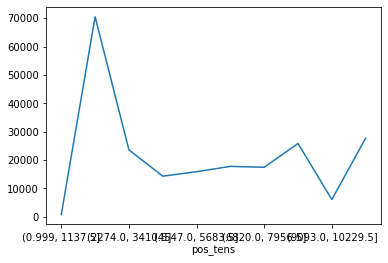

In [51]:
movies['pos_tens'] = pd.qcut(movies['position_in_franchise'].rank(method='first'), q=10,)
games['pos_tens'] = pd.qcut(games['position_in_franchise'].rank(method='first'), q=10,)
df['pos_tens'] = pd.qcut(df['position_in_franchise'].rank(method='first'), q=10,)

df.groupby('pos_tens')['votes_average'].mean().plot()


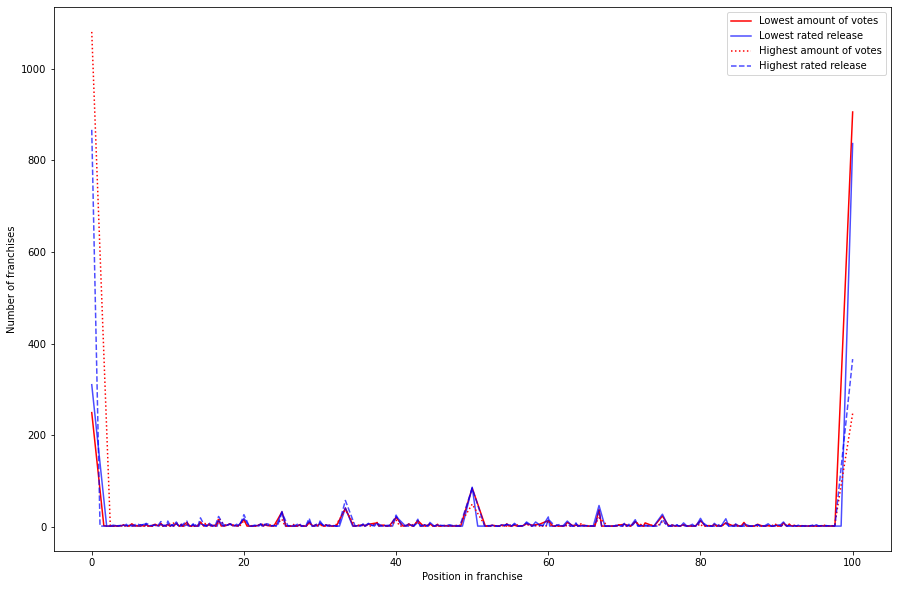

In [50]:
#franchise_grouped_df.groupby((franchise_grouped_df['average_releases_per_year'] // 0.1) * 0.1)['average_rating'].mean().plot()
#df[df["min_rating"] == df["rating_average"]].position_in_franchise.value_counts() // 0.1 * 0.1.sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Lowest rated release")

fig, ax = plt.subplots(figsize=(15, 10))
df[df["min_vote"] == df["votes_average"]].position_in_franchise.value_counts().sort_index().plot(xlabel="Position in franchise", ylabel="Number of franchises", color="red", ax=ax, label = "Lowest amount of votes")
df[df["min_rating"] == df["rating_average"]].position_in_franchise.value_counts().sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Lowest rated release")
df[df["max_vote"] == df["votes_average"]].position_in_franchise.value_counts().sort_index().plot(xlabel="Position in franchise", ylabel="Number of franchises", color="red", ax=ax, label = "Highest amount of votes", linestyle = ':')
df[df["max_rating"] == df["rating_average"]].position_in_franchise.value_counts().sort_index().plot(color="blue", alpha =0.7, ax=ax, label = "Highest rated release", linestyle = '--')

plt.legend()
plt.show()

In [8]:
games_df = df[df["type"] == "game"]
movies_df = df[df["type"] == "movie"]

In [9]:
movies_df

,franchise_id,min_rating,max_rating,min_vote,max_vote,min_year,max_year,franchise_name,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes,position_in_franchise
7305,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0032123,what a life,1939,0,75,"['Comedy', 'Drama']",93.000000,6.90,11.0,1.0,NaN,NaN,NaN,NaN,0.767931,-0.330874,0.000000
7306,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033834,life with henry,1940,0,80,"['Comedy', 'Family', 'Music']",49.000000,6.00,11.0,1.0,1.0,-44.000000,-0.90,0.0,-0.013058,-0.331116,20.000000
7307,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,tt0033708,henry aldrich for president,1941,0,75,"['Comedy', 'Family']",146.000000,6.60,11.0,1.0,1.0,97.000000,0.60,0.0,0.507601,-0.330582,40.000000
7308,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0034842, tt0034844","henry aldrich, editor, henry and dizzy",1942,0,72,"['Comedy', 'Family', 'Drama']",104.000000,6.80,11.0,2.0,1.0,-42.000000,0.20,1.0,0.681154,-0.330813,60.000000
7309,f0,6.00,7.7,49.0,146.0,1939,1944,The Aldrich Family,movie,"tt0035985, tt0035983, tt0035984","henry aldrich swings it, henry aldrich gets gl...",1943,0,64,"['Comedy', 'Family', 'Adventure']",130.333333,7.00,11.0,3.0,1.0,26.333333,0.20,1.0,0.854707,-0.330669,80.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0040018,it's forever springtime,1950,0,92,"['Comedy', 'Drama']",99.000000,6.40,3.0,1.0,2.0,-212.000000,-0.50,0.0,0.334048,-0.330841,50.000000
11379,f993,6.40,7.0,99.0,658.0,1948,1952,Renato Castellani's Italian neorealism trilogy,movie,tt0044572,two cents worth of hope,1952,0,110,"['Comedy', 'Romance']",658.000000,7.00,3.0,1.0,2.0,559.000000,0.60,0.0,0.854707,-0.327767,100.000000
11380,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"['Romance', 'Horror', 'Sci-Fi']",5449.500000,4.25,4.0,2.0,NaN,NaN,NaN,NaN,-1.531648,-0.301416,0.000000
11381,f994,4.25,5.2,2068.0,5449.5,1974,1987,It's Alive,movie,tt0077756,it lives again,1978,0,91,"['Horror', 'Sci-Fi']",2494.000000,5.20,4.0,1.0,4.0,-2955.500000,0.95,-1.0,-0.707271,-0.317670,30.769231


- Define a flop
- Normalise rating diff to see what the biggest drop offs are across both media
- Graph results and use it to define a reasonable threshold for a flop
- stacked bar chart for games and movies showing % of flops that "recovered"\
&nbsp; ie if the content that flopped was the last in the series\
&nbsp; (may need to filter out content that was released in the last year or 2)


In [23]:
games_df.loc[games_df.franchise_name.isin(movies_df.franchise_name),'match']=True

C:\Users\35387\AppData\Local\Temp\ipykernel_106852\3994652624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  games_df.loc[games_df.franchise_name.isin(movies_df.franchise_name),'match']=True


In [30]:
games_df[pd.notnull(games_df["match"])]["franchise_name"].unique()

array(['Commando', 'Peanuts', 'Lucky Luke', 'The Godfather', 'X-Men',
       'Pirates of the Caribbean', 'Dead or Alive', 'Cars', 'Die Hard',
       'Madagascar', 'Starship Troopers', 'The Punisher',
       'FIFA World Cup', 'Blair Witch', 'Kung Fu Panda', 'Ice Age',
       'Godzilla', 'Winnie the Pooh', 'Transformers', 'Despicable Me',
       'Tom and Jerry', 'Drift', 'Terminator', 'Alvin and the Chipmunks',
       'Star Trek', 'SpongeBob SquarePants', 'Indiana Jones', 'Shrek',
       'James Bond', 'Jaws', 'Jurassic Park', 'Rocky', 'RoboCop',
       'Resident Evil', 'Rambo', 'Jumanji', 'Back to the Future',
       'Pokémon', 'One Piece', 'The Lord of the Rings', 'Mickey Mouse',
       'Mission: Impossible', 'Star Wars', 'Spider-Man', 'Sailor Moon',
       'Evil Dead', 'Ghostbusters', 'The Matrix', 'Home Alone',
       'Mortal Kombat', 'Bleach', 'Nancy Drew', 'Blood', 'Toy Story',
       'Digimon', 'Barbie', 'The Flintstones', 'Monty Python',
       'Men in Black', 'Asterix'], dtype=ob

As discussed on Friday it will be interesting to see how you define a "flop" and explore the recovery or otherwise after a flop. try to keep it simple reasonable. If you decide, for example, that a flop is a movie/game that has x% fewer ratings/votes that the preceding title then that's fine as long as you can defend x. You can also write you analysis code in such a way as to make it easy to change x so that you can do a "sensitivity analysis" by varying x. If you find that the outcome is similar for various ranges of x then that's a good sign.
